## CS4243, CW4, Deep Image Classification, Q5
### 2022, Amir

In [1]:
''' 
To run this code on co lab: 

add: import os

add: 
from google.colab import drive
drive.mount('/content/gdrive')
!ls

set the directory, e.g.:
"/content/gdrive/MyDrive/ANN/pets_very_small"
"/content/gdrive/MyDrive/ANN/flst.txt"

flst.txt file should be modified too

'''

' \nTo run this code on co lab: \n\nadd: import os\n\nadd: \nfrom google.colab import drive\ndrive.mount(\'/content/gdrive\')\n!ls\n\nset the directory, e.g.:\n"/content/gdrive/MyDrive/ANN/pets_very_small"\n"/content/gdrive/MyDrive/ANN/flst.txt"\n\nflst.txt file should be modified too\n\n'

In [2]:
# we just need these packages

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [5]:
# to check if we have got GPU or not

In [6]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [7]:
# setting the train and evaluation dataset and directories
# train/evaluation directory is pets_very_small 
#

In [8]:
image_size = (256,256)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/ANN/pets_very_small",
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/ANN/pets_very_small",
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1042 files belonging to 2 classes.
Using 834 files for training.
Found 1042 files belonging to 2 classes.
Using 208 files for validation.


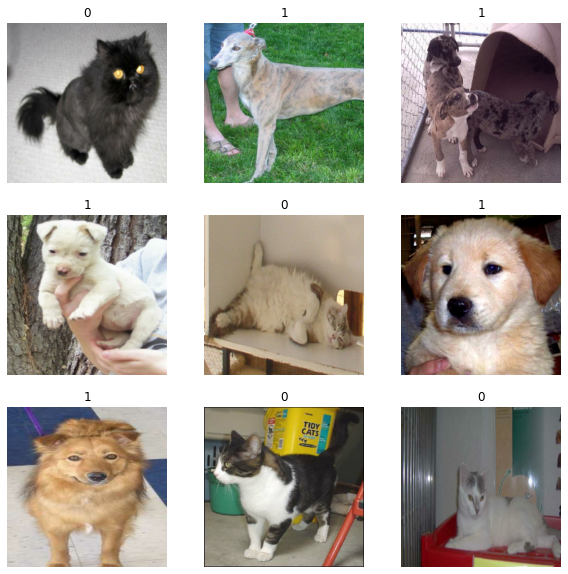

In [9]:
# showing the images 
# 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off") 

In [10]:
# data augmentation, using horizontal flip, and random rotation 
# rotation factor is between 0 to 0.1*2pi 
# 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

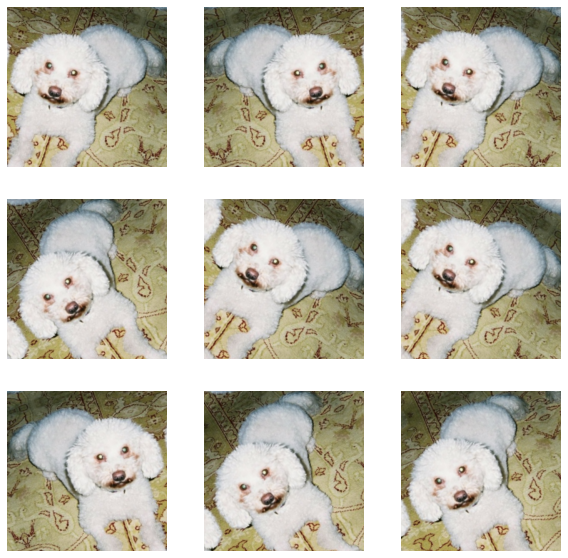

In [11]:
# showing the rotated and flipped images that were added to the 
# original dataset
#
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")  

In [12]:
# setting train and validation datasets via augmentation

In [13]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
train_ds = train_ds.prefetch(buffer_size=16)
val_ds = val_ds.prefetch(buffer_size=16)

In [15]:
# making our deep model: make_model function
# basically, it is a deep convolutional netwrok. Structure is very similar with VGG16 and 19
#

In [16]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)

    previous_block_activation = x  # Set aside residual
    for size in [128, 256, 512, 728]:
        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
   
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(25, activation='relu')(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [17]:
model = make_model(input_shape=image_size + (3,) )


In [18]:
# compiling and training our model

In [19]:
epochs = 100

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [20]:
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/100
53/53 [==============================] - 26s 266ms/step - loss: 0.7120 - accuracy: 0.4976 - val_loss: 0.7007 - val_accuracy: 0.4952
Epoch 2/100
53/53 [==============================] - 11s 206ms/step - loss: 0.6828 - accuracy: 0.5612 - val_loss: 0.6952 - val_accuracy: 0.4952
Epoch 3/100
53/53 [==============================] - 10s 195ms/step - loss: 0.6765 - accuracy: 0.5731 - val_loss: 0.6980 - val_accuracy: 0.5048
Epoch 4/100
53/53 [==============================] - 11s 200ms/step - loss: 0.6761 - accuracy: 0.5947 - val_loss: 0.6993 - val_accuracy: 0.5048
Epoch 5/100
53/53 [==============================] - 10s 196ms/step - loss: 0.6595 - accuracy: 0.6175 - val_loss: 0.7144 - val_accuracy: 0.5048
Epoch 6/100
53/53 [==============================] - 10s 191ms/step - loss: 0.6653 - accuracy: 0.5899 - val_loss: 0.7146 - val_accuracy: 0.5048
Epoch 7/100
53/53 [==============================] - 11s 200ms/step - loss: 0.6512 - accuracy: 0.6091 - val_loss: 0.7568 - val_accuracy:

In [21]:
# above: the last validation accuracy above, is a good metric 
# to show your classifier performance 
# below: testing the classifier with some images  

In [22]:
flst = np.loadtxt('/content/gdrive/MyDrive/ANN/flst.txt', dtype=np.character) 
ddmm =  len(flst)
tags = np.zeros( (1,ddmm) )
tags[:,27:ddmm]= 1
tags = np.int8( tags.T )
len(flst)

63

In [23]:
predct = []
for i in flst:
    i = '/content/gdrive/MyDrive/ANN/' + str(i.decode('utf-8')) 
    img = keras.preprocessing.image.load_img( i , target_size=image_size )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    score = predictions[0]
    print( i , 
        " is %.2f percent cat and %.2f percent dog."
        % (100 * (1 - score), 100 * score)
    )
    predct.append( np.round(score) )


/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/0.jpg  is 99.46 percent cat and 0.54 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/1.jpg  is 99.39 percent cat and 0.61 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/10.jpg  is 99.52 percent cat and 0.48 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/13.jpg  is 99.13 percent cat and 0.87 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/14.jpg  is 99.48 percent cat and 0.52 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/15.jpg  is 99.35 percent cat and 0.65 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/16.jpg  is 99.23 percent cat and 0.77 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/17.jpg  is 99.12 percent cat and 0.88 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/18.jpg  is 99.28 percent cat and 0.72 percent dog.
/content/gdrive/MyDrive/ANN/pets_tiny_test/Cat/2.jpg  is 99.36 percent cat and 0.64 percent dog.
/content/gdrive/MyDrive

In [26]:
predct = np.int8( np.array(predct) )
sscc = np.sum(abs(tags-predct))
print('Number of correct classification =' , ddmm-sscc , ' out of ', ddmm , ' means ', round((ddmm-sscc)/ddmm,3) )

Number of correct classification = 28  out of  63  means  0.444


In [25]:
#model.save('resul_saved1')